In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, roc_curve
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
plt.rcParams.update({
    'text.usetex':False,
    'font.family':'monospace'
})  
import seaborn as sns

import optuna
from xgboost import XGBClassifier

In [2]:
def bootstrap_auc_ci(y_true, y_scores, n_bootstraps=2000, ci=0.95):
    rng = np.random.default_rng(42)
    aucs = []

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    for _ in range(n_bootstraps):
        idx = rng.integers(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[idx], y_scores[idx]))

    lower = np.percentile(aucs, (1 - ci) / 2 * 100)
    upper = np.percentile(aucs, (1 + ci) / 2 * 100)
    return np.mean(aucs), lower, upper

## Loading the dataset, pre-processing, and analysing the data

In [3]:
cohort_data = pd.read_csv('../cohort_data_new.csv')
cohort_data

,icustay_id,anion_gap_mean,anion_gap_sd,anion_gap_min,anion_gap_max,bicarbonate_mean,bicarbonate_sd,bicarbonate_min,bicarbonate_max,calcium_total_mean,...,urea_nitrogen_min,urea_nitrogen_max,white_blood_cells_mean,white_blood_cells_sd,white_blood_cells_min,white_blood_cells_max,age,gender,icu_los_hours,target
0,200003,13.375000,3.583195,9.0,21.0,25.250000,3.105295,18.0,28.0,7.771429,...,10.0,21.0,26.471429,13.176711,13.2,43.9,48,M,141,0
1,200007,15.500000,2.121320,14.0,17.0,23.000000,1.414214,22.0,24.0,8.900000,...,8.0,10.0,10.300000,1.272792,9.4,11.2,44,M,30,0
2,200009,9.500000,2.121320,8.0,11.0,23.333333,2.081666,21.0,25.0,8.000000,...,15.0,21.0,12.471429,1.471637,10.5,14.3,47,F,51,0
3,200012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.900000,NaN,4.9,4.9,33,F,10,0
4,200014,10.000000,1.732051,9.0,12.0,24.000000,1.000000,23.0,25.0,7.733333,...,21.0,24.0,13.233333,2.203028,10.7,14.7,85,M,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30484,299992,15.375000,2.856153,11.0,25.0,23.125000,2.609556,15.0,26.0,8.307143,...,8.0,23.0,14.134783,3.781727,8.1,22.1,41,M,499,0
30485,299993,9.400000,1.341641,8.0,11.0,29.600000,2.073644,26.0,31.0,8.000000,...,12.0,15.0,12.600000,0.605530,12.0,13.3,26,M,67,0
30486,299994,16.157895,2.477973,13.0,24.0,21.631579,3.451417,17.0,31.0,8.100000,...,28.0,63.0,10.076190,2.642329,5.3,14.5,74,F,152,1
30487,299998,11.500000,1.732051,10.0,14.0,23.500000,1.290994,22.0,25.0,8.800000,...,20.0,22.0,9.900000,1.210372,7.9,11.0,87,M,46,1


In [4]:
lab_cols = [
    'anion_gap_mean', 'anion_gap_min', 'anion_gap_max', 'anion_gap_sd',
    'bicarbonate_mean', 'bicarbonate_min', 'bicarbonate_max', 'bicarbonate_sd',
    'calcium_total_mean', 'calcium_total_min', 'calcium_total_max', 'calcium_total_sd',
    'chloride_mean', 'chloride_min', 'chloride_max', 'chloride_sd',
    'creatinine_mean', 'creatinine_min', 'creatinine_max', 'creatinine_sd',
    'glucose_mean', 'glucose_min', 'glucose_max', 'glucose_sd',
    'hematocrit_mean', 'hematocrit_min', 'hematocrit_max', 'hematocrit_sd',
    'hemoglobin_mean', 'hemoglobin_min', 'hemoglobin_max', 'hemoglobin_sd',
    'mchc_mean', 'mchc_min', 'mchc_max', 'mchc_sd',
    'mcv_mean', 'mcv_min', 'mcv_max', 'mcv_sd',
    'magnesium_mean', 'magnesium_min', 'magnesium_max', 'magnesium_sd',
    'pt_mean', 'pt_min', 'pt_max', 'pt_sd',
    'phosphate_mean', 'phosphate_min', 'phosphate_max', 'phosphate_sd',
    'platelet_count_mean', 'platelet_count_min', 'platelet_count_max', 'platelet_count_sd',
    'potassium_mean', 'potassium_min', 'potassium_max', 'potassium_sd',
    'rdw_mean', 'rdw_min', 'rdw_max', 'rdw_sd',
    'red_blood_cells_mean', 'red_blood_cells_min', 'red_blood_cells_max', 'red_blood_cells_sd',
    'sodium_mean', 'sodium_min', 'sodium_max', 'sodium_sd',
    'urea_nitrogen_mean', 'urea_nitrogen_min', 'urea_nitrogen_max', 'urea_nitrogen_sd',
    'white_blood_cells_mean', 'white_blood_cells_min', 'white_blood_cells_max', 'white_blood_cells_sd',
    'age', 'icu_los_hours'
]

In [5]:
# REmove the ICUstay_id and the gender
drop_cols = [c for c in cohort_data.columns if 'icustay_id' in c.lower() or 'gender' in c.lower()]
df = cohort_data.drop(columns=['icustay_id', 'gender'], errors='ignore')

X = df.drop(columns=['target'])
y = df['target']
imputer = SimpleImputer(strategy="median")
df[lab_cols] = imputer.fit_transform(df[lab_cols])

# Keep only numeric
X = X.select_dtypes(include=['number']).replace([np.inf, -np.inf], np.nan)

print(f"Final feature matrix shape: {X.shape}")

Final feature matrix shape: (30489, 94)


In [6]:
# Test-Train split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print(f"Train Full: {X_train_full.shape}, Test: {X_test.shape}")

Train Full: (21342, 94), Test: (9147, 94)


In [7]:
def objective(trial):
    # Train-Dev split for 
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

    # Handle imbalance
    scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

    params = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 2.0),
        "n_estimators": trial.suggest_int("n_estimators", 300, 5000),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "scale_pos_weight": scale_pos_weight,
        "random_state": 42,
        "eval_metric": "auc",
        "tree_method": "hist",
        "use_label_encoder": False
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)

    return auc

Hyperparameters

In [8]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25, show_progress_bar=True)

print("Search for hyperparameters complete:")
print(study.best_params)

[I 2025-11-28 10:55:31,801] A new study created in memory with name: no-name-931df90f-0ea4-4da3-9c4d-776eeef3814a


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:55:31] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:56:08,023] Trial 0 finished with value: 0.7062832015279136 and parameters: {'learning_rate': 0.00376498150214109, 'max_depth': 7, 'min_child_weight': 11, 'gamma': 0.6632123268679723, 'subsample': 0.6473758501536231, 'colsample_bytree': 0.7684571149526935, 'reg_alpha': 0.44708428971813263, 'reg_lambda': 0.1436392327241615, 'n_estimators': 4188, 'max_delta_step': 1}. Best is trial 0 with value: 0.7062832015279136.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:56:08] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:56:17,266] Trial 1 finished with value: 0.6665528737012449 and parameters: {'learning_rate': 0.19247832151582214, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 0.702826440281871, 'subsample': 0.4349373776913535, 'colsample_bytree': 0.8955228976724436, 'reg_alpha': 0.3701049294273453, 'reg_lambda': 0.8707933024984363, 'n_estimators': 1533, 'max_delta_step': 6}. Best is trial 0 with value: 0.7062832015279136.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:56:17] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:59:28,201] Trial 2 finished with value: 0.7144465601930479 and parameters: {'learning_rate': 0.0014517836696497585, 'max_depth': 19, 'min_child_weight': 8, 'gamma': 0.07348797839024657, 'subsample': 0.43569834271924623, 'colsample_bytree': 0.8614942017432009, 'reg_alpha': 0.9556363079859156, 'reg_lambda': 0.36004605973097004, 'n_estimators': 4162, 'max_delta_step': 9}. Best is trial 2 with value: 0.7144465601930479.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:59:28] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:00:30,099] Trial 3 finished with value: 0.7111571429388319 and parameters: {'learning_rate': 0.0025522316066203424, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.29235632195257266, 'subsample': 0.45905427925417813, 'colsample_bytree': 0.4851948839035982, 'reg_alpha': 0.9793510230817248, 'reg_lambda': 1.7185159969789718, 'n_estimators': 3363, 'max_delta_step': 5}. Best is trial 2 with value: 0.7144465601930479.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:00:30] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:02:17,628] Trial 4 finished with value: 0.7093767690803355 and parameters: {'learning_rate': 0.007971660829463222, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.24764873521612374, 'subsample': 0.8685492092731869, 'colsample_bytree': 0.4792254145017354, 'reg_alpha': 0.9119293429361597, 'reg_lambda': 0.39844008007279785, 'n_estimators': 3658, 'max_delta_step': 8}. Best is trial 2 with value: 0.7144465601930479.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:02:17] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:03:54,410] Trial 5 finished with value: 0.7166154884234242 and parameters: {'learning_rate': 0.0074744968629183615, 'max_depth': 15, 'min_child_weight': 7, 'gamma': 0.5769282509622061, 'subsample': 0.44454001185090725, 'colsample_bytree': 0.9527887398360457, 'reg_alpha': 0.005974715270446828, 'reg_lambda': 0.6549448113446407, 'n_estimators': 2542, 'max_delta_step': 4}. Best is trial 5 with value: 0.7166154884234242.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:03:54] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:05:05,045] Trial 6 finished with value: 0.7083875136522967 and parameters: {'learning_rate': 0.0010983337862955672, 'max_depth': 16, 'min_child_weight': 13, 'gamma': 0.7199221737533495, 'subsample': 0.4857903096932721, 'colsample_bytree': 0.9027973270457812, 'reg_alpha': 0.26571432187322735, 'reg_lambda': 0.37238367804912675, 'n_estimators': 1435, 'max_delta_step': 2}. Best is trial 5 with value: 0.7166154884234242.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:05:05] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:05:30,304] Trial 7 finished with value: 0.6783553199640895 and parameters: {'learning_rate': 0.21830889459367936, 'max_depth': 19, 'min_child_weight': 12, 'gamma': 0.6737230016809752, 'subsample': 0.8085379453206287, 'colsample_bytree': 0.9271632414296189, 'reg_alpha': 0.453913705876909, 'reg_lambda': 0.3578924633664049, 'n_estimators': 3408, 'max_delta_step': 5}. Best is trial 5 with value: 0.7166154884234242.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:05:30] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:06:22,373] Trial 8 finished with value: 0.7134049828738728 and parameters: {'learning_rate': 0.005472952641388048, 'max_depth': 19, 'min_child_weight': 4, 'gamma': 0.4314951582527744, 'subsample': 0.4393929578149056, 'colsample_bytree': 0.7482450566343258, 'reg_alpha': 0.6542158555509384, 'reg_lambda': 1.2457107961438891, 'n_estimators': 845, 'max_delta_step': 5}. Best is trial 5 with value: 0.7166154884234242.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:06:22] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:07:19,601] Trial 9 finished with value: 0.6978996906432449 and parameters: {'learning_rate': 0.010239246644540083, 'max_depth': 5, 'min_child_weight': 8, 'gamma': 0.7177261443434355, 'subsample': 0.927155539665225, 'colsample_bytree': 0.8462835049539628, 'reg_alpha': 0.9836608221986243, 'reg_lambda': 1.0865892801751555, 'n_estimators': 4790, 'max_delta_step': 2}. Best is trial 5 with value: 0.7166154884234242.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:07:19] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:07:54,178] Trial 10 finished with value: 0.7055787144254027 and parameters: {'learning_rate': 0.050002904033900945, 'max_depth': 24, 'min_child_weight': 15, 'gamma': 0.47190118555544275, 'subsample': 0.6408999900459966, 'colsample_bytree': 0.6136573899537109, 'reg_alpha': 0.0002597269721864512, 'reg_lambda': 1.9295367573111335, 'n_estimators': 2046, 'max_delta_step': 0}. Best is trial 5 with value: 0.7166154884234242.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:07:54] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:09:01,376] Trial 11 finished with value: 0.7035172890970327 and parameters: {'learning_rate': 0.027015719098479107, 'max_depth': 13, 'min_child_weight': 8, 'gamma': 0.9836252133172866, 'subsample': 0.5445937994846219, 'colsample_bytree': 0.9846144798109923, 'reg_alpha': 0.7421377301280867, 'reg_lambda': 0.7227350541814752, 'n_estimators': 2762, 'max_delta_step': 10}. Best is trial 5 with value: 0.7166154884234242.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:09:01] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:13:22,865] Trial 12 finished with value: 0.7109246965044402 and parameters: {'learning_rate': 0.0010368415233166712, 'max_depth': 24, 'min_child_weight': 6, 'gamma': 0.05939737579494975, 'subsample': 0.575705574465553, 'colsample_bytree': 0.99968581703987, 'reg_alpha': 0.053200299668153, 'reg_lambda': 0.011906233245354003, 'n_estimators': 2447, 'max_delta_step': 10}. Best is trial 5 with value: 0.7166154884234242.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:13:23] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:17:14,335] Trial 13 finished with value: 0.7173462794274899 and parameters: {'learning_rate': 0.002059842521975081, 'max_depth': 19, 'min_child_weight': 10, 'gamma': 0.0009187194620377537, 'subsample': 0.7394396265568225, 'colsample_bytree': 0.6526144473070716, 'reg_alpha': 0.17908100562832396, 'reg_lambda': 0.6384191240025887, 'n_estimators': 4972, 'max_delta_step': 7}. Best is trial 13 with value: 0.7173462794274899.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:17:14] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:17:35,838] Trial 14 finished with value: 0.712855174148983 and parameters: {'learning_rate': 0.021492321187994178, 'max_depth': 14, 'min_child_weight': 10, 'gamma': 0.2633098125980584, 'subsample': 0.7768735334463652, 'colsample_bytree': 0.6442695931828939, 'reg_alpha': 0.17523236909057668, 'reg_lambda': 1.3273536576227276, 'n_estimators': 454, 'max_delta_step': 3}. Best is trial 13 with value: 0.7173462794274899.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:17:36] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:21:49,958] Trial 15 finished with value: 0.7170077596509586 and parameters: {'learning_rate': 0.002488044889692852, 'max_depth': 17, 'min_child_weight': 5, 'gamma': 0.5113779255546084, 'subsample': 0.729221805452751, 'colsample_bytree': 0.5691629973221286, 'reg_alpha': 0.1831587587076798, 'reg_lambda': 0.6755586769453307, 'n_estimators': 4994, 'max_delta_step': 8}. Best is trial 13 with value: 0.7173462794274899.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:21:50] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:26:32,114] Trial 16 finished with value: 0.715657111488515 and parameters: {'learning_rate': 0.0021494643152456063, 'max_depth': 22, 'min_child_weight': 1, 'gamma': 0.8902076282131128, 'subsample': 0.719579710537413, 'colsample_bytree': 0.570913082376545, 'reg_alpha': 0.18808306126482438, 'reg_lambda': 0.6612971712660148, 'n_estimators': 4925, 'max_delta_step': 7}. Best is trial 13 with value: 0.7173462794274899.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:26:32] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:27:12,216] Trial 17 finished with value: 0.7052870842125126 and parameters: {'learning_rate': 0.06744744208882679, 'max_depth': 21, 'min_child_weight': 4, 'gamma': 0.372264877736609, 'subsample': 0.7525368056451437, 'colsample_bytree': 0.550453590555759, 'reg_alpha': 0.2618841821742132, 'reg_lambda': 0.952762105336104, 'n_estimators': 4360, 'max_delta_step': 8}. Best is trial 13 with value: 0.7173462794274899.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:27:12] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:29:15,232] Trial 18 finished with value: 0.7118041617346851 and parameters: {'learning_rate': 0.003306320583509197, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 0.17184866482401379, 'subsample': 0.8329791619927863, 'colsample_bytree': 0.681017780244611, 'reg_alpha': 0.5479897482406582, 'reg_lambda': 1.5460705201747258, 'n_estimators': 4972, 'max_delta_step': 7}. Best is trial 13 with value: 0.7173462794274899.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:29:15] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:30:03,874] Trial 19 finished with value: 0.7082256874753401 and parameters: {'learning_rate': 0.014033767965524475, 'max_depth': 17, 'min_child_weight': 5, 'gamma': 0.5706044520536956, 'subsample': 0.9991602567461502, 'colsample_bytree': 0.5356077946395842, 'reg_alpha': 0.1347863769156214, 'reg_lambda': 0.5326056307584912, 'n_estimators': 3775, 'max_delta_step': 7}. Best is trial 13 with value: 0.7173462794274899.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:30:04] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:32:28,406] Trial 20 finished with value: 0.7144082479886094 and parameters: {'learning_rate': 0.0018472196134864624, 'max_depth': 12, 'min_child_weight': 14, 'gamma': 0.14793436208288924, 'subsample': 0.6836608480767229, 'colsample_bytree': 0.41412022932321185, 'reg_alpha': 0.32824542520893785, 'reg_lambda': 1.1696573099659768, 'n_estimators': 4484, 'max_delta_step': 9}. Best is trial 13 with value: 0.7173462794274899.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:32:28] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:33:57,464] Trial 21 finished with value: 0.7148239639979642 and parameters: {'learning_rate': 0.004297803258704266, 'max_depth': 16, 'min_child_weight': 7, 'gamma': 0.5722942282572536, 'subsample': 0.6110167075648231, 'colsample_bytree': 0.7456485497623816, 'reg_alpha': 0.08724566158972169, 'reg_lambda': 0.7570771446608106, 'n_estimators': 2981, 'max_delta_step': 4}. Best is trial 13 with value: 0.7173462794274899.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:33:57] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:34:56,456] Trial 22 finished with value: 0.7115948741701406 and parameters: {'learning_rate': 0.005432626882649217, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.5276699788785653, 'subsample': 0.7158687394004771, 'colsample_bytree': 0.6812353052906838, 'reg_alpha': 0.014968183153123343, 'reg_lambda': 0.571201914961189, 'n_estimators': 2223, 'max_delta_step': 6}. Best is trial 13 with value: 0.7173462794274899.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:34:56] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:36:02,369] Trial 23 finished with value: 0.7175126801960212 and parameters: {'learning_rate': 0.007016279495713262, 'max_depth': 18, 'min_child_weight': 6, 'gamma': 0.8330494433115034, 'subsample': 0.5173581010881821, 'colsample_bytree': 0.8198100446974683, 'reg_alpha': 0.25804770055836257, 'reg_lambda': 0.8758805054640171, 'n_estimators': 1829, 'max_delta_step': 4}. Best is trial 23 with value: 0.7175126801960212.


C:\Users\risha\AppData\Local\Temp\ipykernel_24464\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:36:02] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 11:37:38,551] Trial 24 finished with value: 0.7124589001538206 and parameters: {'learning_rate': 0.0031488169994195016, 'max_depth': 21, 'min_child_weight': 5, 'gamma': 0.8189258099893799, 'subsample': 0.5213730403467549, 'colsample_bytree': 0.8043940016528935, 'reg_alpha': 0.23641182884820044, 'reg_lambda': 0.9006478041370489, 'n_estimators': 1801, 'max_delta_step': 6}. Best is trial 23 with value: 0.7175126801960212.
Search for hyperparameters complete:
{'learning_rate': 0.007016279495713262, 'max_depth': 18, 'min_child_weight': 6, 'gamma': 0.8330494433115034, 'subsample': 0.5173581010881821, 'colsample_bytree': 0.8198100446974683, 'reg_alpha': 0.25804770055836257, 'reg_lambda': 0.8758805054640171, 'n_estimators': 1829, 'max_delta_step': 4}


In [ ]:
# using the best hyperparams for final training on complete training set
best_params = study.best_params
best_params.update({
    "random_state": 7,
    "eval_metric": "auc",
    "tree_method": "hist",
    "use_label_encoder": False,
    "scale_pos_weight": (y_train_full.value_counts()[0] / y_train_full.value_counts()[1])
})

final_model = XGBClassifier(**best_params)
final_model.fit(X_train_full, y_train_full)

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:37:38] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8198100446974683, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=0.8330494433115034, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.007016279495713262,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=4, max_depth=18, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1829, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluate

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      8164
           1       0.44      0.11      0.17       983

    accuracy                           0.89      9147
   macro avg       0.67      0.55      0.56      9147
weighted avg       0.85      0.89      0.86      9147

ROC-AUC: 0.7353
95% CI = [0.7182, 0.7513]


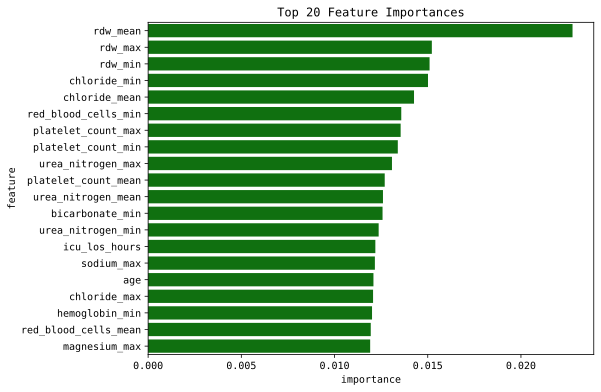

In [10]:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
auprc = average_precision_score(y_test, y_proba)

np.savez(f'../results/xgboost_imputed_fpr_tpr_thresholds.npz', fpr, tpr, thresholds)
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc:.4f}")
_, lower, upper = bootstrap_auc_ci(y_test, y_proba)
print(f"95% CI = [{lower:.4f}, {upper:.4f}]")

importances = final_model.feature_importances_
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(y='feature', x='importance', data=feat_imp, color='green')
plt.title("Top 20 Feature Importances")
plt.show()